## Visualisation des données

-------
Examinons les données de plus près.

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [ ]:
# Téléchargement et extraction du fichier zip
import requests, zipfile, io
zip_file_url = 'https://moncoachdata.com/wp-content/uploads/cell_images.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
# Chemin d'accès du dossier cell_images
my_data_dir = 'cell_images'

In [ ]:
# Confirmez que cela retourne 'test' et 'train'
os.listdir(my_data_dir)

['train', 'test']

In [ ]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

In [ ]:
os.listdir(test_path)

['uninfected', 'parasitized']

In [ ]:
os.listdir(train_path)

['uninfected', 'parasitized']

In [ ]:
os.listdir(train_path+'parasitized')[0]

'C132P93ThinF_IMG_20151004_152045_cell_120.png'

In [ ]:
para_cell = train_path+'/parasitized'+'/C59P20thinF_IMG_20150803_113809_cell_41.png'

In [ ]:
para_img = imread(para_cell)

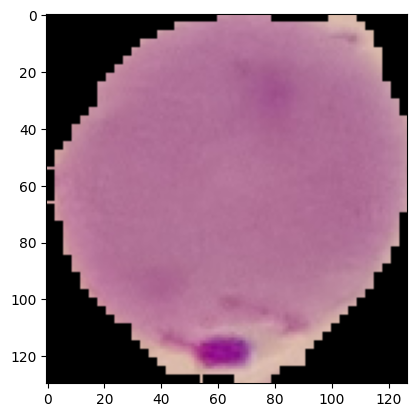

In [ ]:
plt.imshow(para_img);

In [ ]:
para_img.shape

(130, 127, 3)

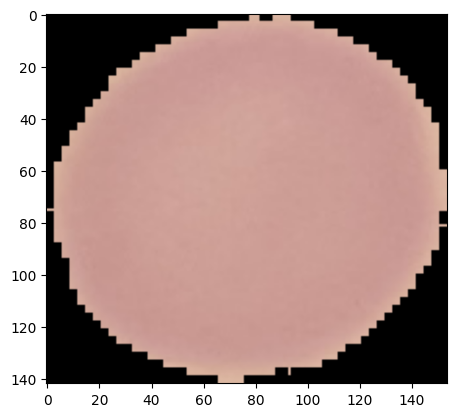

In [ ]:
unifected_cell_path = train_path+'uninfected/'+os.listdir(train_path+'/uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell);

**Vérifions combien d'images il y a.**

In [ ]:
len(os.listdir(train_path+'parasitized'))

12480

In [ ]:
len(os.listdir(train_path+'uninfected'))

12480

**Découvrons les dimensions moyennes de ces images.**

In [ ]:
unifected_cell.shape

(142, 154, 3)

In [84]:
para_img.shape

(130, 127, 3)

In [ ]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'uninfected'):

    img = imread(test_path+'uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

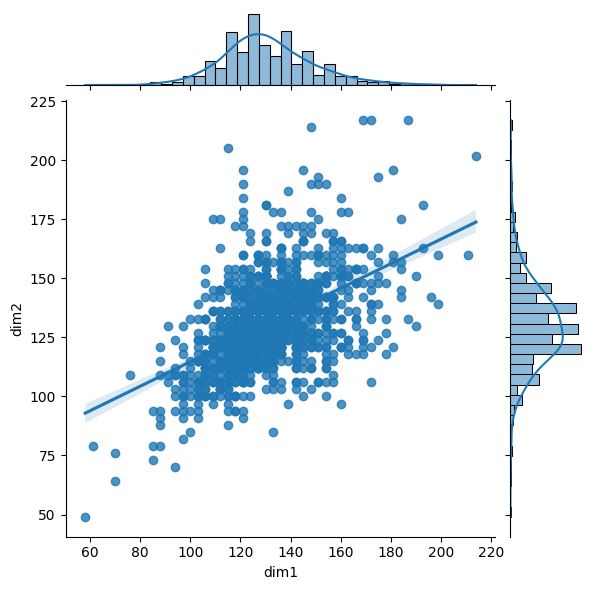

In [90]:
data = pd.DataFrame({'dim1': dim1, 'dim2': dim2})
sns.jointplot(data=data, x='dim1', y='dim2', kind="reg")


In [ ]:
np.mean(dim1)

130.92538461538462

In [ ]:
np.mean(dim2)

130.75

In [ ]:
image_shape = (130,130,3)

### Manipulation des images

C'est généralement une bonne idée de manipuler les images avec une rotation, un redimensionnement et une mise à l'échelle afin que le modèle devienne plus robuste aux différentes images que notre ensemble de données n'a pas. Nous pouvons utiliser le générateur **ImageDataGenerator** pour le faire automatiquement pour nous. Consultez la documentation pour une liste complète de tous les paramètres que vous pouvez utiliser ici !

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_gen = ImageDataGenerator(rotation_range=20, # Faire pivoter l'image de 20 degrés
                               width_shift_range=0.10, # Modifier la largeur de la photo de 10% maximum
                               height_shift_range=0.10, # Modifier la hauteur de la photo de 10% maximum
                               # rescale=1/255, # Redimensionner l'image en la normalisant
                               shear_range=0.1, # shear signifie couper une partie de l'image (max 10%)
                               zoom_range=0.1, # Zoom de 10% maximum
                               horizontal_flip=True, # Autorise le basculement horizontal
                               fill_mode='nearest' # Remplir les pixels manquants avec la valeur remplie la plus proche
                              )

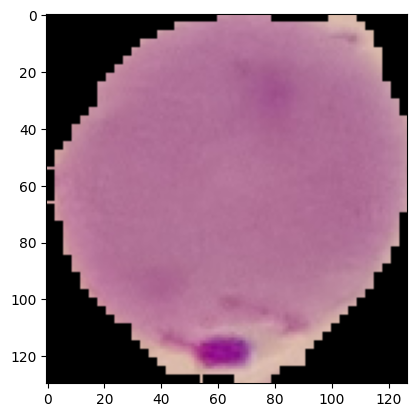

In [ ]:
plt.imshow(para_img);

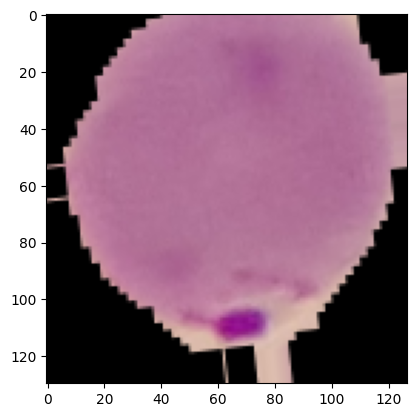

In [ ]:
plt.imshow(image_gen.random_transform(para_img));

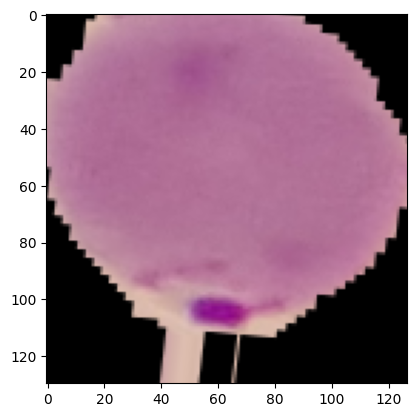

In [ ]:
plt.imshow(image_gen.random_transform(para_img));

### Génération de nombreuses images manipulées à partir d'un répertoire


Pour utiliser .flow_from_directory, vous devez organiser les images dans des sous-répertoires. C'est une exigence absolue, sinon la méthode ne fonctionnera pas. Les répertoires ne doivent contenir que les images d'une seule classe, donc un dossier par classe d'images.

Structure nécessaire :

* Dossier de données d'images
    * Classe 1
        * 0.jpg
        * 1.jpg
        * …
    * Classe 2
        * 0.jpg
        * 1.jpg
        * …
    * …
    * Classe n

In [ ]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [ ]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


## Création du Modèle

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [ ]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Les couches Dropout aident à réduire l'overfitting en désactivant les neurones de façon aléatoire pendant l'entraînement.
# Ici nous demandons de désactiver aléatoirement 50% des neurones.
model.add(Dropout(0.5))

# Dernière couche, n'oubliez pas c'est binaire, nous utilisons donc la sigmoïde
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

### Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

### Entraînement du Modèle

In [ ]:
batch_size = 16

In [ ]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [ ]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [ ]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [ ]:
results = model.fit(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 827s 529ms/step - loss: 0.8970 - accuracy: 0.5461 - val_loss: 0.6867 - val_accuracy: 0.5477
Epoch 2/20
1560/1560 [==============================] - 772s 495ms/step - loss: 0.6820 - accuracy: 0.5714 - val_loss: 0.6836 - val_accuracy: 0.5562
Epoch 3/20
1560/1560 [==============================] - 772s 495ms/step - loss: 0.6849 - accuracy: 0.5611 - val_loss: 0.6785 - val_accuracy: 0.5812
Epoch 4/20
1560/1560 [==============================] - 763s 489ms/step - loss: 0.6758 - accuracy: 0.5798 - val_loss: 0.6734 - val_accuracy: 0.5881
Epoch 5/20
1560/1560 [==============================] - 770s 494ms/step - loss: 0.6751 - accuracy: 0.5856 - val_loss: 0.6723 - val_accuracy: 0.5892
Epoch 6/20
1560/1560 [==============================] - 762s 488ms/step - loss: 0.6687 - accuracy: 0.5910 - val_loss: 0.6654 - val_accuracy: 0.6027
Epoch 7/20
1560/1560 [==============================] - 754s 483ms/step - loss: 0.6372 - accuracy: 0.6359 - val_

In [ ]:
from tensorflow.keras.models import load_model
model.save('malaria_detector.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Évaluation du Modèle

In [ ]:
losses = pd.DataFrame(model.history.history)

<Axes: >

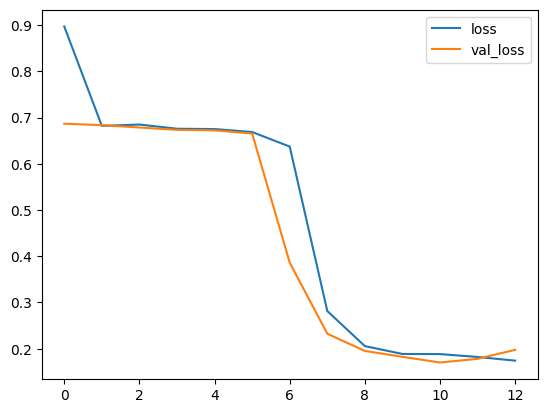

In [ ]:
losses[['loss','val_loss']].plot()

In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
model.evaluate(test_image_gen)

163/163 [==============================] - 32s 193ms/step - loss: 0.1825 - accuracy: 0.9415


[0.1824886053800583, 0.9415384531021118]

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras

pred_probabilities = model.predict(test_image_gen)

163/163 [==============================] - 33s 202ms/step


In [ ]:
pred_probabilities

array([[9.4451904e-03],
       [5.0485494e-05],
       [9.8716351e-04],
       ...,
       [9.6453297e-01],
       [9.8744893e-01],
       [7.9924405e-01]], dtype=float32)

In [ ]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
predictions = pred_probabilities > 0.5

In [ ]:
# Numpy peut traiter cela comme True/False pour nous

predictions

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      1300
           1       0.92      0.96      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



In [ ]:
confusion_matrix(test_image_gen.classes,predictions)

## Prédiction sur une image

In [69]:
para_cell

'cell_images/train//parasitized/C59P20thinF_IMG_20150803_113809_cell_41.png'

In [70]:
my_image = image.load_img(para_cell,target_size=image_shape)

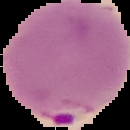

In [71]:
my_image

In [72]:
type(my_image)

PIL.Image.Image

In [73]:
my_image = image.img_to_array(my_image)

In [74]:
type(my_image)

numpy.ndarray

In [75]:
my_image.shape

(130, 130, 3)

In [76]:
my_image = np.expand_dims(my_image, axis=0)

In [77]:
my_image.shape

(1, 130, 130, 3)

In [78]:
(model.predict(my_image) > 0.5).astype('int32')

1/1 [==============================] - 0s 57ms/step


array([[0]], dtype=int32)

In [79]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [80]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}